# 動作價值方法
估計動作最自然的方法，就是對實際收到的獎勵進行平均（樣本平均 Sample-average）。

<img src="https://github.com/Ratherman/Reinforcement-Learning/blob/main/formula_image/img_ch2_01.png?raw=true" alt="drawing" width="400"/>


# 貪婪動作
利用當前知識來最大化立即獎勵
<img src="https://github.com/Ratherman/Reinforcement-Learning/blob/main/formula_image/img_ch2_02.png?raw=true" alt="drawing" width="400"/>


# ɛ-貪婪方法
步驟數量增加至無限大，每個動作都會被採樣無限次，確保收斂發生。
<img src="https://github.com/Ratherman/Reinforcement-Learning/blob/main/formula_image/img_ch2_03.png?raw=true" alt="drawing" width="400"/>

# 10-搖臂拉霸機測試環境（k-armed bandit problem）

In [1]:
# Step 1: Decide 動作值 q*(a)
import numpy as np
import matplotlib.pyplot as plt

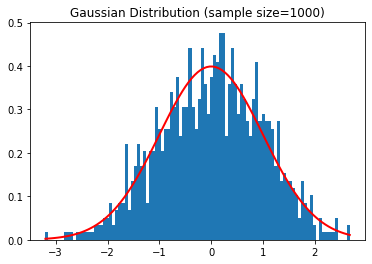

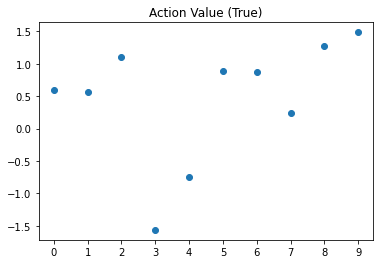

In [3]:
sample_size = 1000
sigma=1
mu=0
# loc: Mean ("centre") of the distribution
# scale: Standard deviation (Spread or "width") of the distribution. Must be non-negative.
gaussian_distribution = [np.random.normal(loc=mu, scale=sigma) for _ in range(sample_size)]

plt.title(f"Gaussian Distribution (sample size={sample_size})")
count, bins, ignored = plt.hist(gaussian_distribution, bins=100, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()

# Derive q*(a), a = a1, a2, a3, ..., a10
action_values_true = gaussian_distribution[:10]

plt.title("Action Value (True)")
plt.plot(action_values_true, "o")
plt.xticks(range(10))
plt.show()

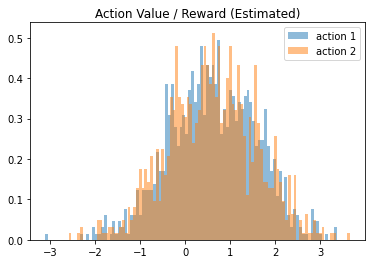

In [5]:
def get_act_reward(action_number):
    mu = action_values_true[action_number]
    sigma = 1
    return np.random.normal(loc=mu, scale=sigma)

# Action 1
action_1_distribution = [get_act_reward(0) for _ in range(sample_size)]

# Action 2
action_2_distribution = [get_act_reward(1) for _ in range(sample_size)]

plt.title("Action Value / Reward (Estimated)")
plt.hist(action_1_distribution, alpha=0.5, bins=100, density=True, label="action 1")
plt.hist(action_2_distribution, alpha=0.5, bins=100, density=True, label="action 2")
plt.legend()
plt.show()

我們可以測量此學習方法在 1000 個時步中逐步提昇的表現和行為。這構成了一個行程（Run）。將學習方法重複 2000 個獨立行程，且每個行程使用不同的拉霸機問題，我們將可以獲得學習演算法平均行為的評估。

學習方法
1. 貪婪方法（Greedy）
2. ɛ-貪婪方法（ɛ-Greedy, where ɛ=0.01）
3. ɛ-貪婪方法（ɛ-Greedy, where ɛ=0.1）

In [6]:
# =============== #
# 貪婪方法（Greedy）#
# =============== #
# 探索 100 次（Exploration）：先對每個 action 隨機抽取 10 次（共100次），平均後取得對該動作的估計值
# 後續 900 次就直接 exploit 當前知識
# 記得! 每次 exploit 都要再次調整當前知識

import random

# 初始化
def init_entity():
    reward_record = list()
    acc_reward_record = list()
    action_record = list()
    count = {}
    reward_memo = {}
    reward_deci = {}
    for idx in range(10):
        _idx = f"_{idx}"
        count[_idx] = 0
        reward_memo[_idx] = list()
        reward_deci[_idx] = -999.0

    # packup
    entity = {
        "reward_record": reward_record,
        "acc_reward_record": acc_reward_record,
        "action_record": action_record,
        "count": count,
        "reward_memo": reward_memo,
        "reward_deci": reward_deci
    }
    return entity
    
def greedy_method(mode, steps, entity, epsilon=None):
    
    #print(mode, steps, len(entity["reward_record"]))
    reward_record = entity["reward_record"]
    acc_reward_record = entity["acc_reward_record"]
    action_record = entity["action_record"]
    count = entity["count"]
    reward_memo = entity["reward_memo"]
    reward_deci = entity["reward_deci"]

    # (隨機地)拉 100 次搖桿 vs. (有意識地)拉 900 次搖桿
    for _ in range(steps): # 100

        if mode == "explore":
            # (隨機地)拉一次搖桿
            action_idx = int(random.randint(0, 9))
        elif mode == "exploit":
            # 選擇最高分的 action 拉
            action_idx = np.argmax(list(reward_deci.values()))
        elif mode == "epsilon":
            if epsilon * 100 > random.randint(0,100):
                # (隨機地)拉一次搖桿
                #print("Hi")
                action_idx = int(random.randint(0, 9)) 
            else:
                #print("Hey")
                action_idx = np.argmax(list(reward_deci.values()))


        key_idx = f"_{action_idx}"

        # 操作該 action
        reward = get_act_reward(action_idx)
        #print(key_idx, reward)

        # 計數 +1
        count[key_idx] += 1
        action_record.append(key_idx)

        # 更新記憶中的 reward
        reward_memo[key_idx].append(reward)
        reward_record.append(reward)
        acc_reward_record.append(sum(reward_record))

        # 為每個動作計算平均 reward
        reward_deci[key_idx] = sum(reward_memo[key_idx])/count[key_idx]

    # pack up
    entity = {
        "reward_record": reward_record,
        "acc_reward_record": acc_reward_record,
        "action_record": action_record,
        "count": count,
        "reward_memo": reward_memo,
        "reward_deci": reward_deci
    }
    return entity

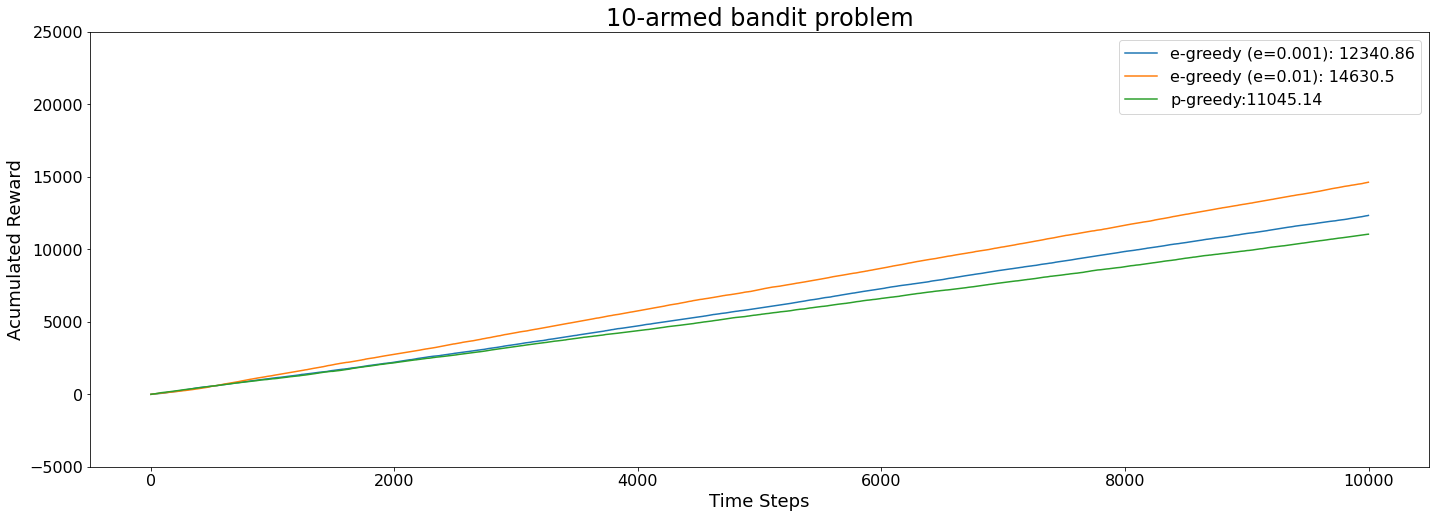

In [7]:
import matplotlib.pyplot as plt

# Greedy: Explore "3" steps, Exploit "10000-3" steps
entity_greedy = init_entity()
explore_steps = 3
entity_greedy = greedy_method(mode="explore", steps=explore_steps, entity=entity_greedy)
entity_greedy = greedy_method(mode="exploit", steps=10000-explore_steps, entity=entity_greedy)

# Epsilon Greedy: 'e' % Explore, '1-e' % Exploit
entity_e_greedy_001 = init_entity()
entity_e_greedy_001 = greedy_method(mode="explore", steps=explore_steps, entity=entity_e_greedy_001)
entity_e_greedy_001 = greedy_method(mode="epsilon", steps=10000-explore_steps, entity=entity_e_greedy_001, epsilon=0.001)

entity_e_greedy_01 = init_entity()
entity_e_greedy_01 = greedy_method(mode="explore", steps=explore_steps, entity=entity_e_greedy_01)
entity_e_greedy_01 = greedy_method(mode="epsilon", steps=10000-explore_steps, entity=entity_e_greedy_01, epsilon=0.01)

plt.figure(figsize=(24, 8))
plt.plot(entity_e_greedy_001["acc_reward_record"], label=f"e-greedy (e=0.001): {round(entity_e_greedy_001['acc_reward_record'][-1], 2)}")
plt.plot(entity_e_greedy_01["acc_reward_record"], label=f"e-greedy (e=0.01): {round(entity_e_greedy_01['acc_reward_record'][-1], 2)}")
plt.plot(entity_greedy["acc_reward_record"], label=f"p-greedy:{round(entity_greedy['acc_reward_record'][-1], 2)}")
plt.legend(fontsize=16)
plt.title("10-armed bandit problem", fontsize=24)
plt.xlabel("Time Steps", fontsize=18)
plt.ylabel("Acumulated Reward",fontsize=18)
plt.ylim([-5000, 25000])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# 目前上面是樣本平均法